<a href="https://colab.research.google.com/github/dlkt101101/STAT441-Project/blob/main/STAT441_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAT 441: Statistical Learning - Classification
## Classifying Astrophysical Images
Prepared by:\
Darren Alexander Lam Kin Teng\
Ojus Udagani\
Raghuv

In [42]:
# !pip install filetype

In [24]:
# ! pip install tensorflow

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import kagglehub
import keras
import os

In [26]:
# importing keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Flatten, RandomFlip, RandomRotation, \
RandomZoom, RandomShear, Normalization, Dropout
from keras.activations import relu, sigmoid, softmax
from keras.applications import VGG16, VGG19, ResNet50
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

## Importing the dataset

In [27]:
path = kagglehub.dataset_download("engeddy/astrophysical-objects-image-dataset")

Using Colab cache for faster access to the 'astrophysical-objects-image-dataset' dataset.


In [28]:
path

'/kaggle/input/astrophysical-objects-image-dataset'

In [29]:
training_path = path+'/astro_dataset_maxia/astro_dataset_maxia/training'
test_path = path+'/astro_dataset_maxia/astro_dataset_maxia/test'
validation_path = path+'/astro_dataset_maxia/astro_dataset_maxia/validation'

Creating training, validation and testing batches for images.

In [30]:
BATCH_SIZE =32
IMAGE_SIZE =(256, 256)

From the TensorFlow documentation the supported image formats: `.jpeg`, `.jpg`, `.png`, `.bmp`, `.gif`. We must verify whether all images are in such format before loading in our batches.

In [44]:
import filetype
import os

def get_file_type(filepath):
    if not os.path.exists(filepath):
        return "File not found"
    try:
        kind = filetype.guess(filepath)
        if kind:
            return f"{kind.mime} ({kind.extension})"
        else:
            # Fallback for common text formats if filetype doesn't detect
            with open(filepath, 'rb') as f:
                header = f.read(256)
                if b'<html' in header.lower() or b'<!doctype html>' in header.lower():
                    return "text/html (html)"
                elif b'{' in header and b'}' in header and (b'json' in header.lower() or b'\"' in header):
                    return "application/json (json)"
                elif b'<?xml' in header.lower():
                    return "text/xml (xml)"
            return "Unknown/Undetectable"
    except Exception as e:
        return f"Error reading file: {e}"

# Collect information for problematic files
problematic_training_info = []
if 'problem_files_training_tf' in locals() and problem_files_training_tf:
    for file_path, _ in problem_files_training_tf:
        file_format = get_file_type(file_path)
        problematic_training_info.append((file_path, file_format))

problematic_validation_info = []
if 'problem_files_validation_tf' in locals() and problem_files_validation_tf:
    for file_path, _ in problem_files_validation_tf:
        file_format = get_file_type(file_path)
        problematic_validation_info.append((file_path, file_format))

problematic_test_info = []
if 'problem_files_test_tf' in locals() and problem_files_test_tf:
    for file_path, _ in problem_files_test_tf:
        file_format = get_file_type(file_path)
        problematic_test_info.append((file_path, file_format))

# Display counts
print("--- Summary of Problematic Image Files ---")
print(f"Total problematic training files: {len(problematic_training_info)}")
print(f"Total problematic validation files: {len(problematic_validation_info)}")
print(f"Total problematic test files: {len(problematic_test_info)}\n")

# Display details for each category
if problematic_training_info:
    print("--- Problematic Training Files Details ---")
    for file_path, file_format in problematic_training_info:
        print(f"File: {file_path}\n  Detected Format: {file_format}\n")
else:
    print("No problematic training files identified.")

if problematic_validation_info:
    print("--- Problematic Validation Files Details ---")
    for file_path, file_format in problematic_validation_info:
        print(f"File: {file_path}\n  Detected Format: {file_format}\n")
else:
    print("No problematic validation files identified.")

if problematic_test_info:
    print("--- Problematic Test Files Details ---")
    for file_path, file_format in problematic_test_info:
        print(f"File: {file_path}\n  Detected Format: {file_format}\n")
else:
    print("No problematic test files identified.")

--- Summary of Problematic Image Files ---
Total problematic training files: 5
Total problematic validation files: 3
Total problematic test files: 1

--- Problematic Training Files Details ---
File: /kaggle/input/astrophysical-objects-image-dataset/astro_dataset_maxia/astro_dataset_maxia/training/galaxy/galaxy_032.jpg
  Detected Format: image/webp (webp)

File: /kaggle/input/astrophysical-objects-image-dataset/astro_dataset_maxia/astro_dataset_maxia/training/galaxy/galaxy_047.jpg
  Detected Format: image/webp (webp)

File: /kaggle/input/astrophysical-objects-image-dataset/astro_dataset_maxia/astro_dataset_maxia/training/black_hole/hole_198.jpg
  Detected Format: image/webp (webp)

File: /kaggle/input/astrophysical-objects-image-dataset/astro_dataset_maxia/astro_dataset_maxia/training/black_hole/hole_220.jpg
  Detected Format: image/webp (webp)

File: /kaggle/input/astrophysical-objects-image-dataset/astro_dataset_maxia/astro_dataset_maxia/training/black_hole/hole_153.jpg
  Detected For

In [39]:
import os

# Function to get all file paths and their labels from a directory
def get_image_paths_and_labels(directory_path, class_names):
    image_paths = []
    labels = []
    class_to_idx = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory_path, class_name)
        if os.path.isdir(class_dir):
            for fname in os.listdir(class_dir):
                fpath = os.path.join(class_dir, fname)
                if os.path.isfile(fpath):
                    image_paths.append(fpath)
                    labels.append(class_to_idx[class_name])
    return image_paths, labels

# Get class names (assuming it's already defined from a successful run of image_dataset_from_directory or manually defined)
# If class_names is not defined, you might need to run a dummy image_dataset_from_directory first or define it manually.
class_names = ['asteroid', 'black_hole', 'earth', 'galaxy', 'jupiter', 'mars', 'mercury', 'neptune', 'pluto', 'saturn', 'uranus', 'venus']

# Collect all image paths and labels for each set
all_training_paths, all_training_labels = get_image_paths_and_labels(training_path, class_names)
all_validation_paths, all_validation_labels = get_image_paths_and_labels(validation_path, class_names)
all_test_paths, all_test_labels = get_image_paths_and_labels(test_path, class_names)

# Create sets of problematic file paths for efficient lookup
# These variables were populated by the previous 'problematic_..._info' steps
problematic_training_paths_set = {f[0] for f in problematic_training_info}
problematic_validation_paths_set = {f[0] for f in problematic_validation_info}
problematic_test_paths_set = {f[0] for f in problematic_test_info}

# Filter out problematic files
filtered_training_paths = []
filtered_training_labels = []
for i, path in enumerate(all_training_paths):
    if path not in problematic_training_paths_set:
        filtered_training_paths.append(path)
        filtered_training_labels.append(all_training_labels[i])

filtered_validation_paths = []
filtered_validation_labels = []
for i, path in enumerate(all_validation_paths):
    if path not in problematic_validation_paths_set:
        filtered_validation_paths.append(path)
        filtered_validation_labels.append(all_validation_labels[i])

filtered_test_paths = []
filtered_test_labels = []
for i, path in enumerate(all_test_paths):
    if path not in problematic_test_paths_set:
        filtered_test_paths.append(path)
        filtered_test_labels.append(all_test_labels[i])

# Convert to TensorFlow datasets
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False) # Decode to 3 channels, TensorFlow supports JPEG, PNG, GIF, BMP
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) # Cast to float32 for model input
    return img, label

# Create TensorFlow datasets from filtered paths and labels
training_ds = tf.data.Dataset.from_tensor_slices((filtered_training_paths, filtered_training_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((filtered_validation_paths, filtered_validation_labels))
test_ds = tf.data.Dataset.from_tensor_slices((filtered_test_paths, filtered_test_labels))

# Apply preprocessing, shuffle, and batch
training_batch = training_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batch = validation_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batch = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Print counts for verification
print(f"Found {len(filtered_training_paths)} files belonging to {len(class_names)} classes for training.")
print(f"Found {len(filtered_validation_paths)} files belonging to {len(class_names)} classes for validation.")
print(f"Found {len(filtered_test_paths)} files belonging to {len(class_names)} classes for testing.")

Found 2416 files belonging to 12 classes.
Found 658 files belonging to 12 classes.
Found 345 files belonging to 12 classes.


Visualizing the Images

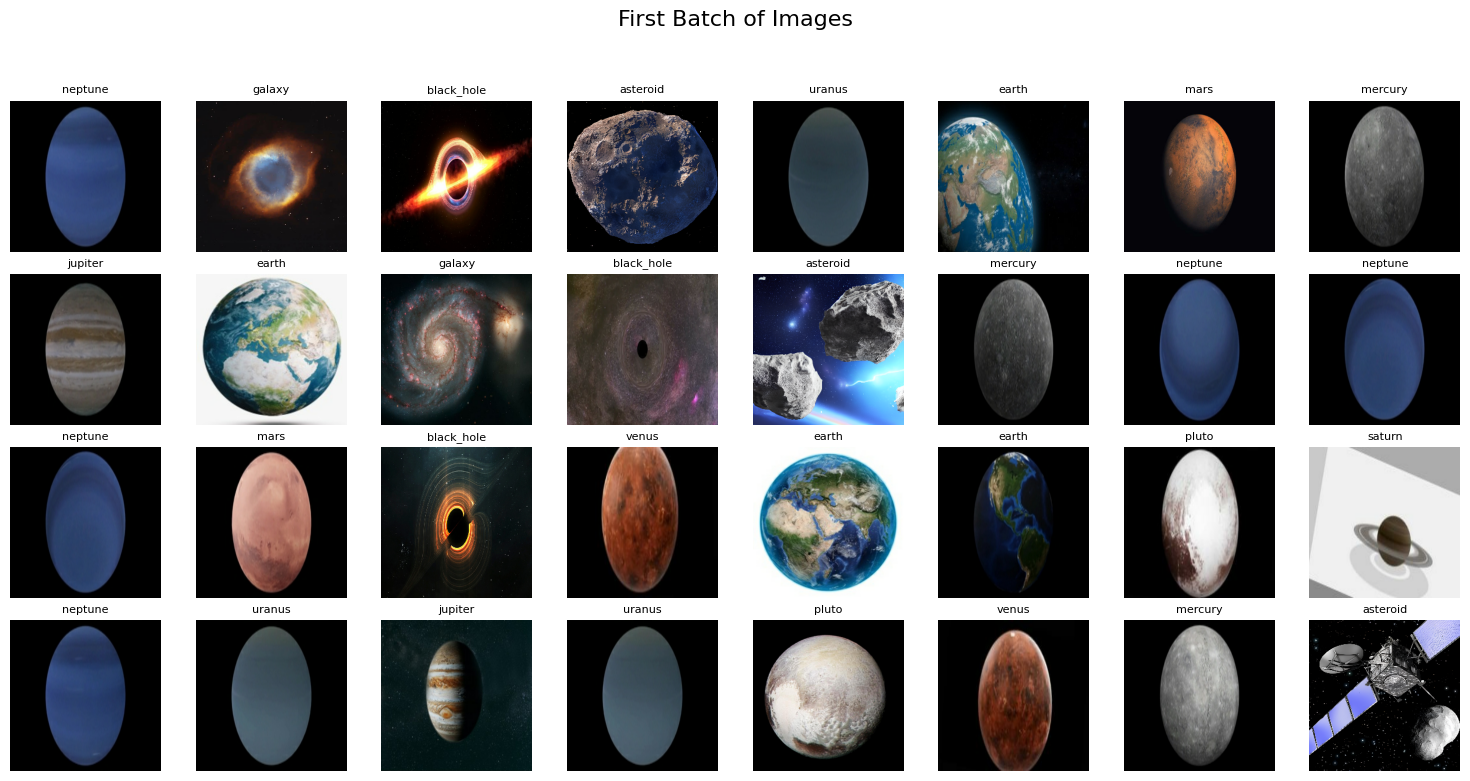

In [32]:
for images, labels in training_batch.take(1):
    num_images = images.shape[0]
    rows = int(num_images / 8) + 1

    plt.figure(figsize=(15, 10))
    plt.suptitle("First Batch of Images", fontsize=16)
    for i in range(num_images):
        plt.subplot(rows, 8, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))

        # Get the class name for the title
        label_index = labels[i].numpy()
        title = training_batch.class_names[label_index]

        plt.title(title, fontsize=8)
        plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    break

Implementing image preprocessing by:
1. Resizing the image (completed and resized to (256,256) )
2. Normalizing the pixel values
3. Data Augmentations\
  3.1. Normalization of pixel values\
  3.2. Random Rotations\
  3.3. Random Shear\
  3.4. Random Zoom\
  3.5. Random Flip

In [33]:
preprocess = [
    Normalization(axis=-1), # we normalize the images per channel (RGB)
    RandomRotation(0.5), # random rotations of images
    RandomShear(x_factor=0.9, y_factor=0.9), # Random shear of images
    RandomZoom(0.2),
    RandomFlip(mode="horizontal_and_vertical") # Random flip of the images
    ]

## Model Implementaion


### Neural Network Implementaion

We will implement multiple pre-trained Convolutional Neural Networks (CNN) and fine-tune them to our astrophysical dataset. Such models include:
* VGG16
* VGG19
* ResNet
#### VGG 16

In [34]:
mVGG16 = VGG16(include_top= False,
              input_shape=(256,256,3),
              pooling='avg',
              weights='imagenet',
              name = "vgg16")

# we will avoid training on previous layers
for layer in mVGG16.layers:
  layer.trainable = False

In [35]:
mVGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [40]:
model = Sequential(preprocess + \
 [mVGG16,
  Dropout(0.5),
  Dense(256, activation='relu'),
  Dense(len(class_names), activation='softmax')
  ])
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False), optimizer = Adam(learning_rate=0.001))

In [41]:
model.fit(x=training_batch, validation_data=validation_batch, epochs=5, verbose=1, batch_size=BATCH_SIZE)

Epoch 1/5
 8/76 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - loss: 6.8104

InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
	 [[StatefulPartitionedCall/Shape/_6]]
  (1) INVALID_ARGUMENT:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_19278]